# Regression

## Objectives

*   Investigate if transforming the numerical features improves the ML model

## Inputs

* outputs/datasets/collection/HousePricesRecords.csv
* Feature datacleaning/engineering pipeline from the FeatureEngineering notebook 

## Outputs

* No output

## Conclusion

*   There is no difference in the performance of the ML model if one includes transformation of numerical features

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues'

---

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv"))
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,No,706.0,GLQ,150.0,0.0,548.0,RFn,...,65.0,196.0,61.0,5,7,856.0,0.0,2003,2003,208500.0
1,1262.0,0.0,3.0,Gd,978.0,ALQ,284.0,NaN,460.0,RFn,...,80.0,0.0,0.0,8,6,1262.0,NaN,1976,1976,181500.0
2,920.0,866.0,3.0,Mn,486.0,GLQ,434.0,0.0,608.0,RFn,...,68.0,162.0,42.0,5,7,920.0,NaN,2001,2002,223500.0


___

# ML Pipeline for Regressor

## Create ML pipeline

* We need our custom encoder from the DataCleaning notebook

In [5]:
### Custom Encoder
from sklearn.base import BaseEstimator, TransformerMixin
class MyCustomEncoder(BaseEstimator, TransformerMixin):

  def __init__(self, variables, dic):
    if not isinstance(variables, list): 
      self.variables = [variables]
    else: self.variables = variables
    self.dic = dic

  def fit(self, X, y=None):    
    return self

  def transform(self, X):
    for col in self.variables:
      if X[col].dtype == 'object':
        X[col] = X[col].replace(dic[col])
      else:
        print(f"Warning: {col} data type should be object to use MyCustomEncoder()")
      
    return X

### Pipeline from the FeatureEngineering notebook where we add feature scaling, feature selection, transformation of numerical variables and model (as parameter):

In [7]:
from sklearn.pipeline import Pipeline

### Drop features
from feature_engine.selection import DropFeatures

### Median Imputer
from feature_engine.imputation import MeanMedianImputer

### Correlation selection
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from feature_engine import transformation as vt
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Add transformation of numerical variables
def PipelineOptimization(dic, vars_with_missing_data, model):
    
      pipeline = Pipeline([
            ('drop_features', DropFeatures(features_to_drop = ['EnclosedPorch', 'WoodDeckSF'])),
            
            ('custom_encoder', MyCustomEncoder(variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'], dic=dic)),
            
            ('median_imputer',  MeanMedianImputer(imputation_method='median', variables=vars_with_missing_data)),
            
            ('corr_sel', SmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")),

            ('pt', vt.PowerTransformer(variables=['BsmtUnfSF', 'OpenPorchSF'])),

            ('log', vt.LogTransformer(variables=['GrLivArea'])),
            
            ("feat_scaling", StandardScaler() ),

            ("feat_selection",  SelectFromModel(model) ),

            ("model", model ),
      ])

      return pipeline

### Custom Class for hyperparameter Optimization: (From Code Institute Scikit lesson)

In [8]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, dic, vars_with_missing_data, models, params):
        self.dic = dic
        self.vars_with_missing_data = vars_with_missing_data
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(dic, vars_with_missing_data, self.models[key],)

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split the data in Train and Test Set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'],axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Grid Search CV - Sklearn

### Try seven ML algorithms with default hyperparameters

In [10]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [11]:
# Dictionary for MyCustomEncoder
dic = {'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}, 'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}, 'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}, 'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}}

# Variables with missing variables after dropping ['EnclosedPorch', 'WoodDeckSF']. This is a parameter passed to MeanMedianImputer
vars_with_missing_data = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea']     


### Train five models (one for each of the five crossvalidations, cv=5) for each algoritm, and default hyperparameters.

In [12]:
search = HyperparameterOptimizationSearch(dic=dic, vars_with_missing_data=vars_with_missing_data, models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


### Check results

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.674397,0.805334,0.872805,0.0733644
2,RandomForestRegressor,0.630557,0.791425,0.859635,0.0846068
5,GradientBoostingRegressor,0.63931,0.764258,0.850056,0.0835967
0,LinearRegression,0.697861,0.748593,0.795511,0.0331303
6,XGBRegressor,0.637822,0.737927,0.820724,0.0700456
4,AdaBoostRegressor,0.602909,0.712744,0.777303,0.069266
1,DecisionTreeRegressor,0.49583,0.621785,0.672732,0.0669374


### Conduct hyperparameter optimization on the top four models using hyperparameter combinations from Code Institute Scikit lesson

In [14]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "LinearRegression": LinearRegression(),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                           'model__max_depth': [None, 3, 15],
                           'model__min_samples_split': [2, 50],
                           'model__min_samples_leaf': [1,50],
    },
    "RandomForestRegressor":{'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
    },
    "LinearRegression":{},
    "GradientBoostingRegressor":{'model__n_estimators': [100,50,140],
                                 'model__learning_rate':[0.1, 0.01, 0.001],
                                 'model__max_depth': [3,15, None],
                                 'model__min_samples_split': [2,50],
                                 'model__min_samples_leaf': [1,50],
                                 'model__max_leaf_nodes': [None,50],
    }
}

Train models with GridSearchCV, in total 1625 models

In [15]:
search = HyperparameterOptimizationSearch(dic=dic, vars_with_missing_data=vars_with_missing_data, models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


### Check results

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head(50)

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__max_leaf_nodes,model__learning_rate
132,GradientBoostingRegressor,0.76362,0.81304,0.851956,0.0321198,3,50,50,140,50,0.1
129,GradientBoostingRegressor,0.76362,0.81304,0.851956,0.0321198,3,50,2,140,50,0.1
117,GradientBoostingRegressor,0.76362,0.81304,0.851956,0.0321198,3,50,2,140,None,0.1
120,GradientBoostingRegressor,0.76362,0.81304,0.851956,0.0321198,3,50,50,140,None,0.1
115,GradientBoostingRegressor,0.762197,0.812875,0.850881,0.0324312,3,50,2,100,None,0.1
118,GradientBoostingRegressor,0.762197,0.812875,0.850881,0.0324312,3,50,50,100,None,0.1
130,GradientBoostingRegressor,0.762197,0.812875,0.850881,0.0324312,3,50,50,100,50,0.1
127,GradientBoostingRegressor,0.762197,0.812875,0.850881,0.0324312,3,50,2,100,50,0.1
177,GradientBoostingRegressor,0.758101,0.811575,0.855133,0.034728,None,50,2,140,50,0.1
168,GradientBoostingRegressor,0.758101,0.811575,0.855133,0.034728,None,50,50,140,None,0.1


### We look at all four algoritms

### 1. GradientBoostingRegressor

In [17]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Access best model parameters

In [18]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

Access best pipeline

In [19]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop_features',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('custom_encoder',
                 MyCustomEncoder(dic={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                       'Mn': 2, 'No': 1,
                                                       'None': 0},
                                      'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                       'GLQ': 6, 'LwQ': 2,
                                                       'None': 0, 'Rec': 3,
                                                       'Unf': 1},
                                      'GarageFinish': {'Fin': 3, 'None': 0,
                                                       'RFn': 2, 'Unf': 1},
                                      'KitchenQual': {'Ex': 4, 'Fa': 1, 'Gd': 3,
                                                      '...
    

## Assess feature importance
Code from Code Institute Scikit lesson

* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


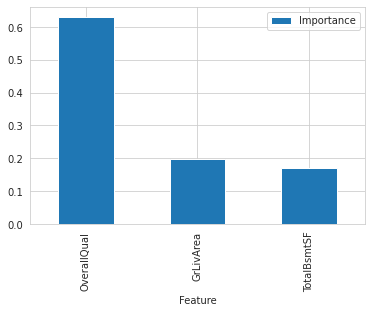

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 4 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()
best_features

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate on Train and Test Sets
Code from Code Institute Scikit lesson

In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].tick_params(axis='x', rotation=90)
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].tick_params(axis='x', rotation=90)
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

### Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.834
Mean Absolute Error: 21359.496
Mean Squared Error: 1024460750.793
Root Mean Squared Error: 32007.198


* Test Set
R2 Score: 0.761
Mean Absolute Error: 24335.071
Mean Squared Error: 1648866814.119
Root Mean Squared Error: 40606.241




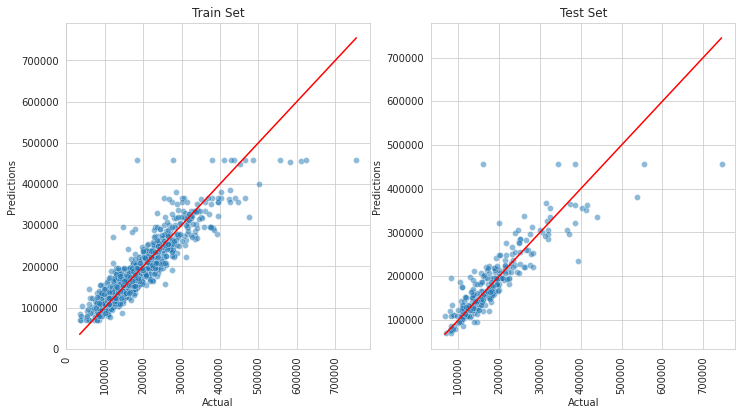

In [22]:
import numpy as np

regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### The R2 score on the test set is 0.76. It passes the performance goal of an R2 score of at least 0.75 but the model does not predict sale prices above $457199 which is unnatural.

### 2. ExtraTreesRegressor

In [23]:
best_model = grid_search_summary.iloc[24,0]
best_model

'ExtraTreesRegressor'

Access best model parameters

In [24]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

Access best pipeline

In [25]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop_features',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('custom_encoder',
                 MyCustomEncoder(dic={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                       'Mn': 2, 'No': 1,
                                                       'None': 0},
                                      'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                       'GLQ': 6, 'LwQ': 2,
                                                       'None': 0, 'Rec': 3,
                                                       'Unf': 1},
                                      'GarageFinish': {'Fin': 3, 'None': 0,
                                                       'RFn': 2, 'Unf': 1},
                                      'KitchenQual': {'Ex': 4, 'Fa': 1, 'Gd': 3,
                                                      '...
    

## Assess feature importance
Code from Code Institute Scikit lesson

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'GarageArea', 'YearBuilt']


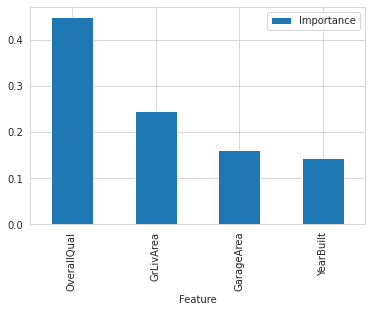

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 4 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()
best_features

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate on Train and Test Sets
Code from Code Institute Scikit lesson

### Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.996
Mean Absolute Error: 2944.992
Mean Squared Error: 22629243.528
Root Mean Squared Error: 4757.02


* Test Set
R2 Score: 0.848
Mean Absolute Error: 20771.777
Mean Squared Error: 1046813174.251
Root Mean Squared Error: 32354.492




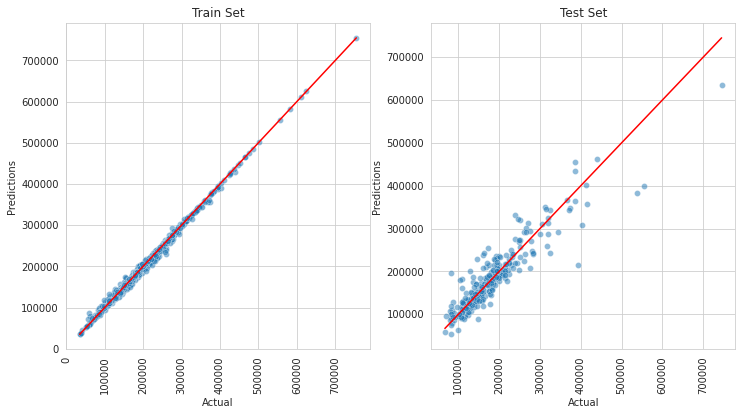

In [27]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### The R2 score on the test set is 0.85. It passes the performance goal of 0.75 but the model looks overfitted. The algorithm trains on five features which is more than the other algorithms and is likely the reason for the overfitting.

### 3. RandomForestRegressor

In [28]:
best_model = grid_search_summary.iloc[48,0]
best_model

'RandomForestRegressor'

Access best model parameters

In [29]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [30]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop_features',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('custom_encoder',
                 MyCustomEncoder(dic={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                       'Mn': 2, 'No': 1,
                                                       'None': 0},
                                      'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                       'GLQ': 6, 'LwQ': 2,
                                                       'None': 0, 'Rec': 3,
                                                       'Unf': 1},
                                      'GarageFinish': {'Fin': 3, 'None': 0,
                                                       'RFn': 2, 'Unf': 1},
                                      'KitchenQual': {'Ex': 4, 'Fa': 1, 'Gd': 3,
                                                      '...
    

## Assess feature importance
Code from Code Institute Scikit lesson

* These are the 2 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea']


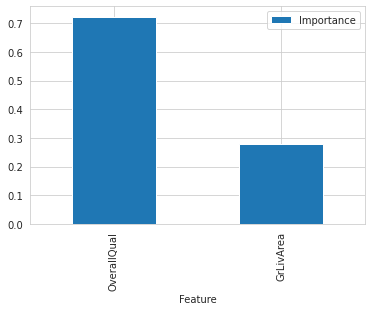

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 4 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()
best_features

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

### Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.864
Mean Absolute Error: 21879.46
Mean Squared Error: 840082093.12
Root Mean Squared Error: 28984.17


* Test Set
R2 Score: 0.796
Mean Absolute Error: 24290.252
Mean Squared Error: 1408021936.115
Root Mean Squared Error: 37523.618




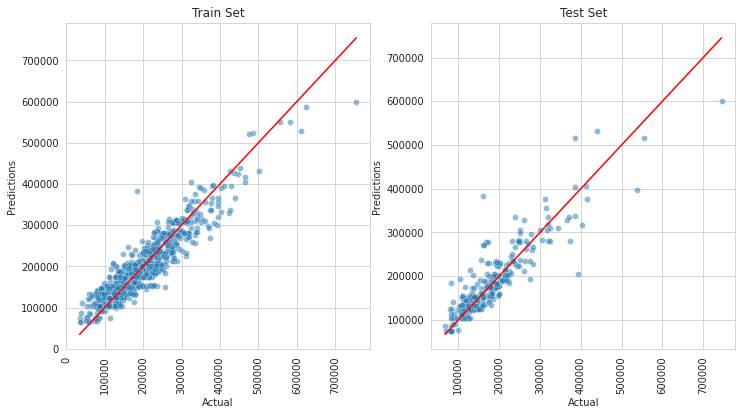

In [32]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### The R2 score on the test set is 0.8. It passes the performance goal of 0.75. It looks like the best model. The model may still have problems with prices above $400000 though, like the GradientBoostingRegressor model. 

### 4. LinearRegression	

### Go back to the results of the main search

In [45]:
grid_search_summary.head(105)

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__max_leaf_nodes,model__learning_rate
132,GradientBoostingRegressor,0.76362,0.81304,0.851956,0.0321198,3,50,50,140,50,0.1
129,GradientBoostingRegressor,0.76362,0.81304,0.851956,0.0321198,3,50,2,140,50,0.1
117,GradientBoostingRegressor,0.76362,0.81304,0.851956,0.0321198,3,50,2,140,None,0.1
120,GradientBoostingRegressor,0.76362,0.81304,0.851956,0.0321198,3,50,50,140,None,0.1
115,GradientBoostingRegressor,0.762197,0.812875,0.850881,0.0324312,3,50,2,100,None,0.1
...,...,...,...,...,...,...,...,...,...,...,...
111,GradientBoostingRegressor,0.634989,0.757639,0.842089,0.081528,3,1,2,140,None,0.1
126,GradientBoostingRegressor,0.648741,0.757328,0.849679,0.0831696,3,1,50,140,50,0.1
108,LinearRegression,0.697861,0.748593,0.795511,0.0331303,NaN,NaN,NaN,NaN,NaN,NaN
149,GradientBoostingRegressor,0.616339,0.746061,0.835636,0.0799778,15,1,50,50,50,0.1


In [46]:
best_model = grid_search_summary.iloc[102,0]
best_model

'LinearRegression'

Access best model parameters

In [47]:
grid_search_pipelines[best_model].best_params_

{}

In [48]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop_features',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('custom_encoder',
                 MyCustomEncoder(dic={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                       'Mn': 2, 'No': 1,
                                                       'None': 0},
                                      'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                       'GLQ': 6, 'LwQ': 2,
                                                       'None': 0, 'Rec': 3,
                                                       'Unf': 1},
                                      'GarageFinish': {'Fin': 3, 'None': 0,
                                                       'RFn': 2, 'Unf': 1},
                                      'KitchenQual': {'Ex': 4, 'Fa': 1, 'Gd': 3,
                                                      '...
    

## Assess feature importance
### The LinearRegression model has no feature importance so we display only the best features.

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 4 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()
best_features

# # create DataFrame to display feature importance
# df_feature_importance = (pd.DataFrame(data={
#           'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
#           'Importance': best_regressor_pipeline['model'].feature_importances_})
#   .sort_values(by='Importance', ascending=False)
#   )

# # Most important features statement and plot
# print(f"* These are the {len(best_features)} most important features in descending order. "
#       f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
# plt.show()

['GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']

### Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.763
Mean Absolute Error: 25988.031
Mean Squared Error: 1459395082.939
Root Mean Squared Error: 38202.03


* Test Set
R2 Score: 0.653
Mean Absolute Error: 28882.384
Mean Squared Error: 2395031816.926
Root Mean Squared Error: 48939.062




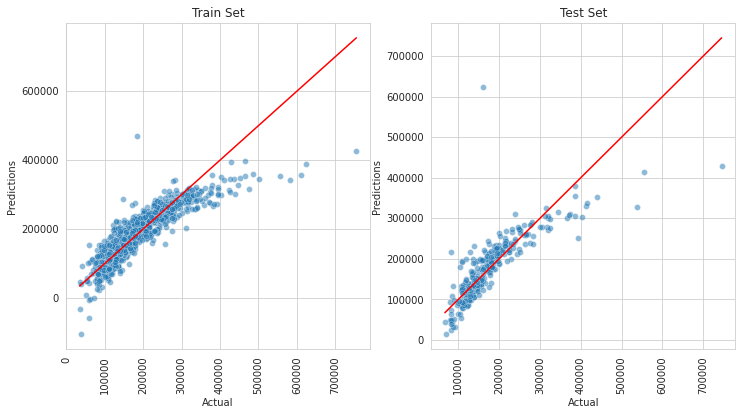

In [50]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### The R2 score on the test set is 0.65. It does not pass the performance goal of 0.75.